<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>
<h1 align="center"><font size="3">This Project created by Teguh BDS</font></h1>

In this notebook we try to practice all the classification algorithms that we learned.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-05-07 02:09:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-05-07 02:09:07 (12.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [158]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [161]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



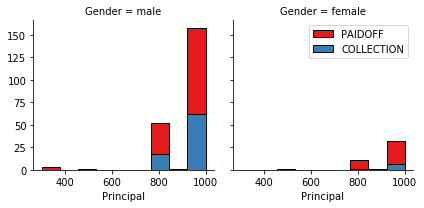

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

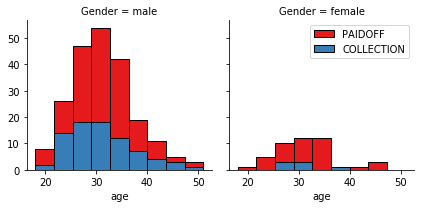

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

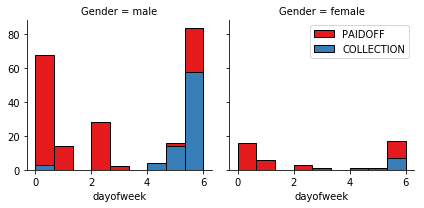

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [171]:
Feature.describe()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,943.641618,22.653179,30.939306,0.150289,0.592486,0.127168,0.436416,0.430636
std,109.425530,7.991006,6.039418,0.357872,0.492084,0.333643,0.496659,0.495882
min,300.000000,7.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,900.000000,15.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1000.000000,30.000000,30.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1000.000000,30.000000,35.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1000.000000,30.000000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(K-NN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

<h3>Split the dataset into training and test sets </h3>

I will use 80% of the data for training and 20% for validation for all the models.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_val.shape,  y_val.shape)


Train set: (276, 8) (276,)
Validation set: (70, 8) (70,)


<h3>Train models for different k values </h3>

In [91]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 8
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_val)
    mean_acc[n-1] = metrics.accuracy_score(y_val, yhat)

    
    std_acc[n-1]=np.std(yhat==y_val)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.67142857,  0.65714286,  0.71428571,  0.68571429,  0.75714286,
        0.71428571,  0.78571429])

<h3>Plotting accuracy</h3>

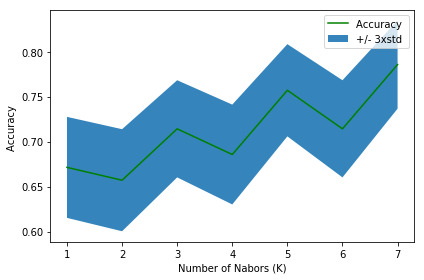

In [131]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.9)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

<h3>Best accuracy</h3>

In [26]:
print( "This is The best accuracy", mean_acc.max(), "with k=", mean_acc.argmax()+1)

This is The best accuracy 0.785714285714 with k= 7


<h3>The best KNN model</h3>

In [92]:
KNN_best = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
KNN_valid_preds = KNN_best.predict(X_val)
KNN_valid_preds[0:5]
#KNN_valid_preds.shape

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

<h3>F1_Score</h3>

In [99]:
f1_val_knn = metrics.f1_score(y_val, KNN_valid_preds, average='weighted')
f1_val_knn

0.77665402444163512

<h3>Jaccard_Score</h3>

In [100]:
jaccard_val_knn = jaccard_similarity_score(y_val, KNN_valid_preds)
jaccard_val_knn

0.7857142857142857

# Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

<h3>Define tree model</h3>

In [35]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
loanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

<h3>lets fit the tree model</h3>

In [36]:
loanTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

<h3>Prediction</h3>

In [47]:
preds = loanTree.predict(X_val)

In [48]:
preds_true_df = pd.DataFrame({"Actual":y_val, "Predicted":preds})
print(preds_true_df.head(10))

       Actual   Predicted
0     PAIDOFF     PAIDOFF
1     PAIDOFF     PAIDOFF
2     PAIDOFF     PAIDOFF
3     PAIDOFF     PAIDOFF
4     PAIDOFF     PAIDOFF
5     PAIDOFF     PAIDOFF
6  COLLECTION  COLLECTION
7     PAIDOFF  COLLECTION
8     PAIDOFF     PAIDOFF
9     PAIDOFF     PAIDOFF


<h3>Model Evaluation</h3>

In [40]:
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_val, preds))

DecisionTrees's Accuracy:  0.757142857143


<h3>F1_Score</h3>

In [42]:
f1_val_tree = metrics.f1_score(y_val, preds, average='weighted')
f1_val_tree

0.69788106630211888

<h3>Jaccard_Score</h3>

In [43]:
jaccard_val_tree= jaccard_similarity_score(y_val, preds)
jaccard_val_tree

0.75714285714285712

# Support Vector Machine(SVM)

<h3>Create SVM model</h3>

In [49]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<h3>Predict</h3>

In [50]:
preds_svm = clf.predict(X_val)
preds_true_svm_df = pd.DataFrame({"Actual":y_val, "Predicted":preds_svm})
print(preds_true_svm_df.head(15))

        Actual   Predicted
0      PAIDOFF  COLLECTION
1      PAIDOFF     PAIDOFF
2      PAIDOFF     PAIDOFF
3      PAIDOFF     PAIDOFF
4      PAIDOFF     PAIDOFF
5      PAIDOFF     PAIDOFF
6   COLLECTION  COLLECTION
7      PAIDOFF  COLLECTION
8      PAIDOFF     PAIDOFF
9      PAIDOFF     PAIDOFF
10  COLLECTION     PAIDOFF
11  COLLECTION     PAIDOFF
12     PAIDOFF     PAIDOFF
13     PAIDOFF     PAIDOFF
14     PAIDOFF     PAIDOFF


<h3>Model Evaluation</h3>

In [51]:
print("SVM Accuracy: ", metrics.accuracy_score(y_val, preds_svm))

SVM Accuracy:  0.742857142857


<h3>F1_Score</h3>

In [101]:
f1_val_svm = metrics.f1_score(y_val, preds_svm, average='weighted')
f1_val_svm

0.72758820127241175

<h3>Jaccard_Score</h3>

In [102]:
jaccard_val_svm = jaccard_similarity_score(y_val, preds_svm)
jaccard_val_svm

0.74285714285714288

# Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
preds_logreg = LR.predict(X_val)
preds_logreg

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

In [57]:
print("Logistic Regression Accuracy: ", metrics.accuracy_score(y_val, preds_logreg))

Logistic Regression Accuracy:  0.685714285714


<h3>Cross_val_score</h3>

In [198]:
from sklearn.model_selection import cross_val_score
Rcross = cross_val_score(LR, X, y, cv=4)
Rcross

array([ 0.52873563,  0.49425287,  0.75581395,  0.75581395])

<h3>Tune the C parameter</h3>

In [59]:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
acc_table = pd.DataFrame(columns = ['C_param','Accuracy'])
acc_table['C_param'] = C_param_range

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    logreg = LogisticRegression(penalty = 'l2', C = i, random_state = 0)
    logreg.fit(X_train, y_train)
    
    # Predict using model
    preds_logreg = logreg.predict(X_val)
    
    # Save accuracy score in table
    acc_table.iloc[j,1] = metrics.accuracy_score(y_val, preds_logreg)
    j += 1

print(acc_table)

   C_param  Accuracy
0    0.001  0.671429
1    0.010  0.685714
2    0.100  0.742857
3    1.000  0.714286
4   10.000  0.714286
5  100.000  0.714286


<h3>The Best C parameter</h3>

In [60]:
print( "The best accuracy is ", acc_table['Accuracy'].max(), "with C=", acc_table[acc_table['Accuracy'] == acc_table['Accuracy'].max()]['C_param'].values[0])

The best accuracy is  0.742857142857 with C= 0.1


<h3>Logistic Regression model with the best C parameter</h3>

In [61]:
LR_best = LogisticRegression(C=0.1, solver='liblinear').fit(X_train, y_train)
LR_best

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
preds_logreg = LR_best.predict(X_val)

<h3>F1_Score</h3>

In [108]:
f1_val_logreg = metrics.f1_score(y_val, preds_logreg, average='weighted')
f1_val_logreg

0.70482060312568784

<h3>Jaccard_Score</h3>

In [109]:
jaccard_val_logreg = jaccard_similarity_score(y_val, preds_logreg)
jaccard_val_logreg

0.74285714285714288

<h3>LogLoss</h3>

In [107]:
preds_logreg_prob = LR_best.predict_proba(X_val)
logreg_val_logloss = log_loss(y_val, preds_logreg_prob)
logreg_val_logloss

0.49819024877442247

# Model Evaluation using Test set

In [206]:
#from sklearn.metrics import jaccard_similarity_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import log_loss

First, download and load the test set:

In [66]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-05-07 02:41:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-05-07 02:41:40 (563 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [67]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


<h3>Pre-process the test set as it was done with the train set</h3>

<h3>Add weekend column</h3>

In [68]:
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male,3,0
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female,3,0
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male,4,1
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male,4,1


<h3>Convert gender to numeric values</h3>

In [69]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,0,3,0
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,1,3,0
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,0,4,1
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,0,4,1


In [70]:
test_df.shape

(54, 12)

In [71]:
test_df.describe()

,Unnamed: 0,Unnamed: 0.1,Principal,terms,age,Gender,dayofweek,weekend
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,182.407407,182.407407,914.814815,21.888889,31.833333,0.203704,5.370370,0.944444
std,116.220759,116.220759,174.190751,8.818220,5.992920,0.406533,0.853324,0.231212
min,1.000000,1.000000,300.000000,7.000000,20.000000,0.000000,3.000000,0.000000
25%,79.500000,79.500000,800.000000,15.000000,28.000000,0.000000,5.000000,1.000000
50%,174.000000,174.000000,1000.000000,30.000000,30.500000,0.000000,6.000000,1.000000
75%,300.250000,300.250000,1000.000000,30.000000,36.000000,0.000000,6.000000,1.000000
max,396.000000,396.000000,1000.000000,30.000000,50.000000,1.000000,6.000000,1.000000


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [72]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [73]:
Feature_test.shape

(54, 8)

In [74]:
Feature_test.describe()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,914.814815,21.888889,31.833333,0.203704,0.944444,0.148148,0.388889,0.425926
std,174.190751,8.818220,5.992920,0.406533,0.231212,0.358583,0.492076,0.499126
min,300.000000,7.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,800.000000,15.000000,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1000.000000,30.000000,30.500000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1000.000000,30.000000,36.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1000.000000,30.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
y_test_new_data = test_df['loan_status'].values
#y_test_new_data[0:5]
y_test_new_data.shape

(54,)

<h3>Normalize the data</h3>

In [76]:
X_test_new_data = Feature_test
X_test_new_data= preprocessing.StandardScaler().fit(X_test_new_data).transform(X_test_new_data)
X_test_new_data[0:5]
X_test_new_data.shape

(54, 8)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

<h1>K-Nearest Neighboar (K-NN)</h1>

In [115]:
KNN_test_preds=KNN_best.predict(X_test_new_data)

In [116]:
knn_test_f1 = metrics.f1_score(y_test_new_data, KNN_test_preds, average='weighted')
knn_test_f1

0.64538101319710506

<h3>Jaccard_Score<h3>

In [117]:
knn_test_jaccard = jaccard_similarity_score(y_test_new_data, KNN_test_preds)
knn_test_jaccard

0.68518518518518523

<h1>Decision Tree</h1>

In [118]:
Tree_test_preds = loanTree.predict(X_test_new_data)
Tree_test_preds

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF'], dtype=object)

<h3>F1_Score</h3>

In [119]:
tree_test_f1 = metrics.f1_score(y_test_new_data, Tree_test_preds, average='weighted')
tree_test_f1

0.64682539682539675

<h3>Jaccard_Score</h3>

In [120]:
tree_test_jaccard = jaccard_similarity_score(y_test_new_data, Tree_test_preds)
tree_test_jaccard

0.66666666666666663

<h1>Support Vector Machine(SVM)</h1>

In [121]:
SVM_test_preds = clf.predict(X_test_new_data)
SVM_test_preds

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION'], dtype=object)

<h3>F1</h3>

In [122]:
svm_test_f1 = metrics.f1_score(y_test_new_data, SVM_test_preds, average='weighted')
svm_test_f1

0.78619528619528622

<h3>Jaccard</h3>

In [123]:
svm_test_jaccard = jaccard_similarity_score(y_test_new_data, SVM_test_preds)
svm_test_jaccard

0.81481481481481477

<h1>Logistic Regression</h1>

In [124]:
LOGREG_test_preds = LR_best.predict(X_test_new_data)
LOGREG_test_preds

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

<h3>F1_Score</h3>

In [125]:
logreg_test_f1 = metrics.f1_score(y_test_new_data, LOGREG_test_preds, average= 'weighted')
logreg_test_f1

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.63041765169424746

<h3>Jaccard_Score</h3>

In [126]:
logreg_test_jaccard = jaccard_similarity_score(y_test_new_data, LOGREG_test_preds)
logreg_test_jaccard

0.7407407407407407

<h3>LogLoss</h3>

In [127]:
preds_test_logreg_prob = LR_best.predict_proba(X_test_new_data)
logreg_test_logloss = log_loss(y_test_new_data, preds_test_logreg_prob)
logreg_test_logloss

0.54739495591742093

<h2>Summary</h2>

<h3>Validation Set Evaluation Model</h3>

In [113]:
train_scores_table = pd.DataFrame({"Algorithm":['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], 
                             "Jaccard":[jaccard_val_knn, jaccard_val_tree, jaccard_val_svm, jaccard_val_logreg],
                             "F1-score": [f1_val_knn, f1_val_tree, f1_val_svm, f1_val_logreg],
                             "LogLos": ['NA', 'NA', 'NA', logreg_valid_logloss]})
print(train_scores_table)

            Algorithm  F1-score   Jaccard   LogLos
0                 KNN  0.776654  0.785714       NA
1       Decision Tree  0.697881  0.757143       NA
2                 SVM  0.727588  0.742857       NA
3  LogisticRegression  0.704821  0.742857  0.49819


<h3>Test Set Evaluation Model</h3>

In [128]:
test_scores_table = pd.DataFrame({"Algorithm":['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], 
                             "Jaccard":[knn_test_jaccard, tree_test_jaccard, svm_test_jaccard, logreg_test_jaccard],
                             "F1-score": [knn_test_f1, tree_test_f1, svm_test_f1, logreg_test_f1],
                             "LogLos": ['NA', 'NA', 'NA', logreg_test_logloss]})
print(test_scores_table)

            Algorithm  F1-score   Jaccard    LogLos
0                 KNN  0.645381  0.685185        NA
1       Decision Tree  0.646825  0.666667        NA
2                 SVM  0.786195  0.814815        NA
3  LogisticRegression  0.630418  0.740741  0.547395


<h2>Conclusion</h2>

KNN gives the best results on the validation set (F1-score 0.776654, Jaccard 0.785714). However, SVM performs better on the test set with unseen data (F1-score 0.786195,  Jaccard 0.814815)

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>